In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Step 1. Library and Dataset Loading
#### - Check the library version

## Import Library

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os

print("Numpy ver.", np.__version__)
print("Pandas ver.", pd.__version__)
print("Matplotlib ver.", matplotlib.__version__)
print("Seaborn ver.", sns.__version__)

print(os.listdir('../input/spaceship-titanic/'))

Numpy ver. 1.20.3
Pandas ver. 1.3.5
Matplotlib ver. 3.5.1
Seaborn ver. 0.11.2
['sample_submission.csv', 'train.csv', 'test.csv']


In [3]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from lightgbm import LGBMClassifier

import time
import warnings
warnings.filterwarnings('ignore')

## Load Data Set

In [4]:
BASE_DIR = '../input/spaceship-titanic/'
train = pd.read_csv(BASE_DIR + "train.csv")
test = pd.read_csv(BASE_DIR + "test.csv")
sample_submission = pd.read_csv(BASE_DIR + "sample_submission.csv")
print("Train Data:",train.shape)
print("Test Data:",test.shape)
print("Submission:",sample_submission.shape)

Train Data: (8693, 14)
Test Data: (4277, 13)
Submission: (4277, 2)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [7]:
train.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [8]:
test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [9]:
sample_submission.head(3)

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False


#### There are a total of 13 features, of which 6 are numerical variables.
#### The target, the column we're going to predict, is 'Trasnported', which is a bool type variable

# Step 2. EDA
#### - data visualization
#### - scatter plot, bar graph, etc
#### - interpretation and description of graphs

## Overview of Data

In [10]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


#### ※ Except Age, more than half of all numeric variables are zero.
   - They are amount the passenger has billed at each of many amenities
   - Preprocessing such as feature engineering and one-hot encoding is required.

In [11]:
train.describe(include=['O'])

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


#### ※ PassengerID, Cabin, and Name are text data, not categorical.
  - They don't seem to be important to the performance of the model.
  - In ML modeling, these features won't be used.

## Missing Value Distribution

In [12]:
train_miss = pd.DataFrame({'dtype' : train.iloc[:, :-1].dtypes,
                           'missing' : train.iloc[:, :-1].isnull().sum()})
test_miss = pd.DataFrame({'dtype' : test.dtypes,
                          'missing' : test.isnull().sum()})

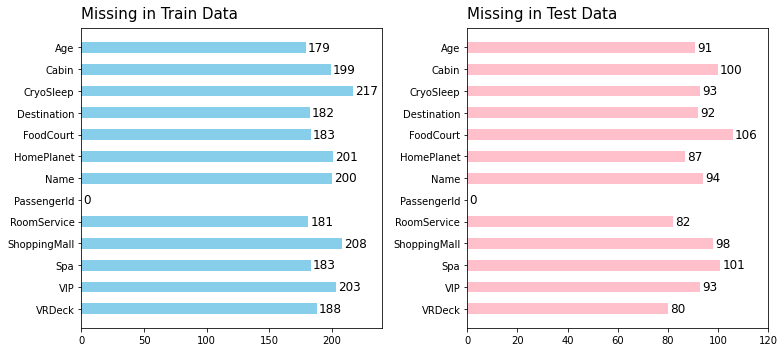

In [13]:
fig, ax = plt.subplots(1,2, figsize=(11,5))
width = 0.5
bar1 = ax[0].barh(sorted(train.columns[:-1].to_list(), reverse=True),
                  train_miss['missing'].sort_index(ascending=False), width, color="skyblue")
bar2 = ax[1].barh(sorted(test.columns.to_list(), reverse=True),
                  test_miss['missing'].sort_index(ascending=False), width, color="pink")

ax[0].set_title("Missing in Train Data", loc="left", pad=10, size=15)
ax[0].set_xlim(0,240)
ax[1].set_title("Missing in Test Data", loc="left", pad=10, size=15)
ax[1].set_xlim(0,120)

ax[0].bar_label(bar1, padding=2, size=12)
ax[1].bar_label(bar2, padding=2, size=12)

fig.tight_layout()
plt.show()

#### The ratio of missing values by feature is less than 10%.
- The numerical features will be replaced by the median value.
- The categorical features will be replaced by the most frequent value.

## Categorical Feature Distribution

In [14]:
train_cat = train.select_dtypes(include = 'object')
test_cat = test.select_dtypes(include = 'object')
col_cat = train_cat.columns.to_list()[1:6]
del col_cat[2]
col_cat

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

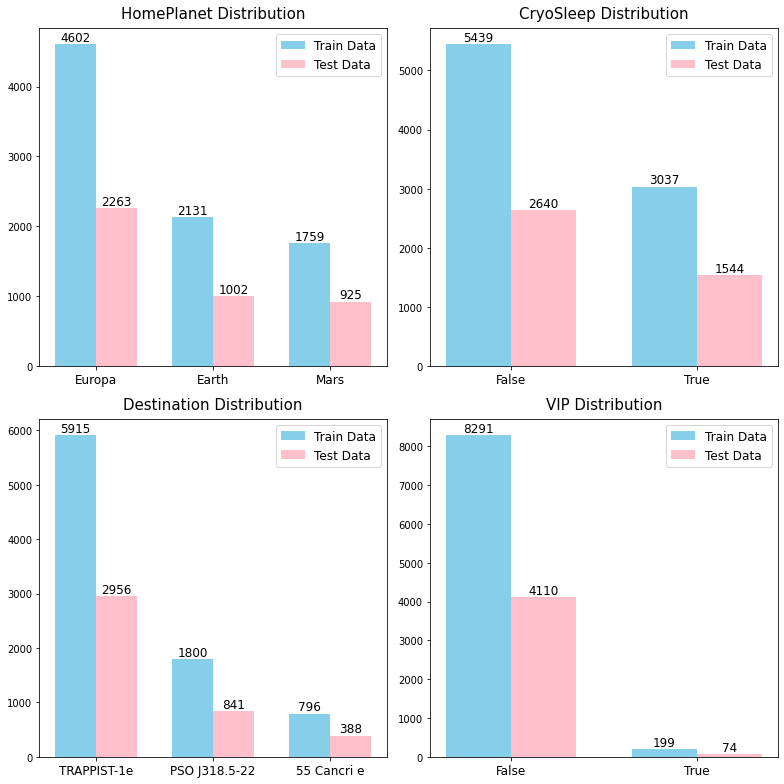

In [15]:
fig, ax = plt.subplots(2,2,figsize=(11,11))

width = 0.35
x = []
b = []
b2 = []

for i in range(2):
    for j in range(2):
        x.append(train_cat.loc[:,col_cat[2*i+j]].unique().tolist()[:-1])
        b.append(ax[i,j].bar(np.arange(len(x[2*i+j])) - width/2,
                               train_cat.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                               width, label = "Train Data", color="skyblue"))
        b2.append(ax[i,j].bar(np.arange(len(x[2*i+j])) + width/2,
                                test_cat.loc[:,col_cat[2*i+j]].value_counts().to_list(),
                                width, label = "Test Data", color="pink"))
        ax[i,j].bar_label(b[2*i+j], label_type='edge', size=12)
        ax[i,j].bar_label(b2[2*i+j], label_type='edge', size=12)
        ax[i,j].set_title(f'{col_cat[2*i+j]} Distribution',
                          pad=10, size=15)
        ax[i,j].set_xticks(np.arange(len(x[2*i+j])), x[2*i+j], size=12)
        ax[i,j].legend(loc="best", fontsize=12)

fig.tight_layout()
plt.show()

## Numeric Feature Distribution

In [16]:
numeric = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train_num = train.select_dtypes(include = numeric)
test_num = test.select_dtypes(include = numeric)
col_num = train_num.columns.to_list()
col_num

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

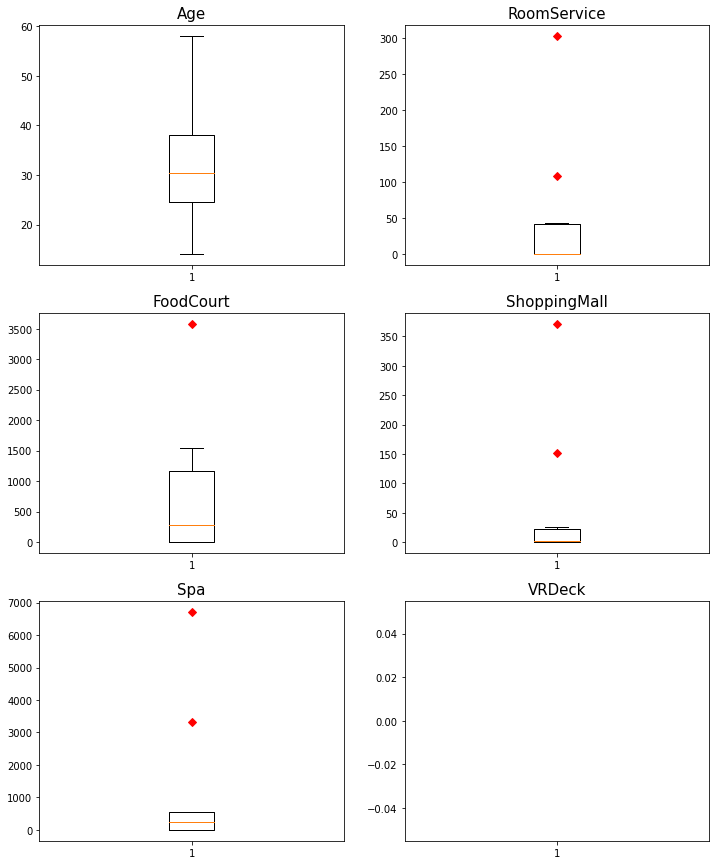

In [17]:
fig, ax = plt.subplots(3,2,figsize=(12,15))

for i in range(3):
    for j in range(2):
        ax[i, j].boxplot(train_num.iloc[:,2*i+j].tolist()[:10], 0, 'rD')
        ax[i, j].set_title(col_num[2*i+j], pad=7, size=15)

plt.show()

## Correlation Matrix

In [18]:
train.iloc[:,:-1].corr().style.background_gradient(
                        cmap="RdBu", axis=None, vmin=-0.5, vmax=0.5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
Age,1.000000,0.068723,0.130421,0.033133,0.123970,0.101007
RoomService,0.068723,1.000000,-0.015889,0.054480,0.010080,-0.019581
FoodCourt,0.130421,-0.015889,1.000000,-0.014228,0.221891,0.227995
ShoppingMall,0.033133,0.054480,-0.014228,1.000000,0.013879,-0.007322
Spa,0.123970,0.010080,0.221891,0.013879,1.000000,0.153821
VRDeck,0.101007,-0.019581,0.227995,-0.007322,0.153821,1.000000


#### There seems to be little correlation between features.
- Issues such as multicollinearity don't have to be considered.

## Target Distribution

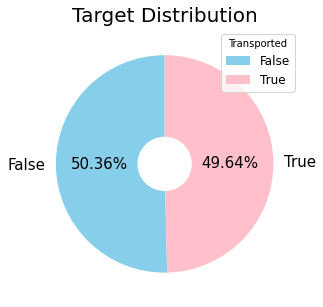

In [19]:
fig, ax = plt.subplots(figsize=(5,5))

pie = ax.pie([train["Transported"].value_counts().to_list()[0],
             train["Transported"].value_counts().to_list()[1]],
             labels = train["Transported"].unique().tolist(),
             textprops=dict(fontsize=15), autopct='%.2f%%',
             colors=["skyblue", "pink"], wedgeprops=dict(width=0.75), startangle=90)

ax.set_title("Target Distribution", size=20)
ax.legend(title="Transported", loc="best", fontsize=12)

plt.show()

# Step 3. Data Preproccessing
#### - Feature engineering, standardization, one-hot encoding, etc
#### - Create derived variables and descibe why you made this variable.

# Step 4. ML Model
#### - Use 1~2 ML model and describe about them
#### - Cross Validation and hyperparameter tuning

In [20]:
train_input = train.iloc[:, :-1].to_numpy()
train_target = train.iloc[:,-1].to_numpy()
print(train_input.shape)
print(train_target.shape)

(8693, 13)
(8693,)


# Step 5. Model Evaluation
#### - Split data set into training data and verification data.
#### - Create Confusion Matrix and compare model accuracy.

# Step 6. Submission
#### - Submit according to the sample given

# Reference
#### - Be sure to link the referenced code in order to prevent plagiarism on your laptop.
#### - Write author name, code title, and url